# modAL + pyhard- Comparando estratégias

- modAL

    - Amostra por incerteza
    - Amostragem aleatória
    - Consulta por comitê
    - Aprendizado passivo
    - Redução do erro esperado

- Pyhard
    - Harmfulness
    - Usefulness
    - H+U
    - Local Set Cardinality 
    - N2
    - F3

In [1]:
%run -i set_environment

## Bibliotecas

In [2]:
%run -i importing_libraries

## Classificadores

### Algoritmos

In [3]:
%run -i classifiers

### Conjunto de dados

In [4]:
%run -i importing_datasets

## Estatratégias

### Amostra por incerteza

In [5]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    accuracy_history.append(learner.score(X_test, y_test))
    f1_history.append(compute_f1(learner, X_test, y_test, "weighted"))
    auc_history.append(compute_auc(learner, X_test, y_test, "weighted","ovo"))

    total_of_samples = 1
    while (total_of_samples != cost):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]
        
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
        accuracy_history.append(learner.score(X_test, y_test))
        f1_history.append(compute_f1(learner, X_test, y_test, "weighted"))
        auc_history.append(compute_auc(learner, X_test, y_test, "weighted", "ovo"))
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "accuracy_history": accuracy_history,
             "f1_history": f1_history,
             "auc_history": auc_history,
             "package": "modAL",
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Uncertain Sampling"}

### Amostragem aleatória

In [6]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()

    for i in range(1, cost+1):

        X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)
        
        cls = which_classifier(classifier)
        cls.fit(X_train, y_train)

        accuracy_history.append(cls.score(X_test,y_test))
        f1_history.append(compute_f1(cls, X_test, y_test, "weighted"))
        auc_history.append(compute_auc(cls, X_test, y_test, "weighted", "ovo"))

        
    end = timer()
    time_elapsed = end - start

    return { "accuracy_history": accuracy_history,
         "f1_history": f1_history,
         "auc_history": auc_history,
         "package": "modAL",
         "time_elapsed": time_elapsed,
         "classifier": classifier,
         "sample_size": sample_size / len(X_raw),
         "Strategy": "Random Sampling"}

### Consulta por comitê

In [7]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()

    learner_list = []

    for j in range(1, cost+1): # Loop para criação do comitê

        X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)

        # initializing learner
        learner = ActiveLearner(
            estimator= which_classifier(classifier),
            X_training = X_train, y_training = y_train 
        )
        learner_list.append(learner)

    # assembling the committee
    committee = Committee(
        learner_list=learner_list,
        query_strategy=vote_entropy_sampling)
    
    # COLOCAR OU NÃO O PRIMEIRO SCORE?
    # accuracy_history.append(committee.score(X_pool, y_pool))
    # f1_history.append(compute_f1(committee, X_pool, y_pool, "weighted"))
    # auc_history.append(compute_auc(committee, X_pool, y_pool, "weighted", "ovo"))
    
    
    # query by committee
    for idx in range(cost):
        # print("\t Size of X_pool:", len(X_pool))
        query_idx, query_instance = committee.query(X_pool, n_instances = init_size+1)
        sample_size = sample_size + len(query_idx)
        
        committee.teach(
            X = X_pool[query_idx],
            y = y_pool[query_idx]
        )

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        accuracy_history.append(committee.score(X_pool, y_pool))
        f1_history.append(compute_f1(committee, X_pool, y_pool, "weighted"))
        auc_history.append(compute_auc(committee, X_pool, y_pool, "weighted", "ovo"))

        
    end = timer()
    time_elapsed = end - start

    return { "accuracy_history": accuracy_history,
         "f1_history": f1_history,
         "auc_history": auc_history,
         "package": "modAL",
         "time_elapsed": time_elapsed,
         "classifier": classifier,
         "sample_size": sample_size / len(X_raw),
         "Strategy": "Query by Committee"}

### Expected Error Reduction

In [8]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    accuracy_history.append(learner.score(X_pool, y_pool))
    f1_history.append(compute_f1(learner, X_pool, y_pool, "weighted"))
    auc_history.append(compute_auc(learner, X_pool, y_pool, "weighted", "ovo"))

    total_of_samples = 1
    while (total_of_samples != cost):
        # print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
    
        # X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        # y_pool = np.delete(y_pool, exp_error_idx)
        
        accuracy_history.append(learner.score(X_pool, y_pool))
        f1_history.append(compute_f1(learner, X_pool, y_pool, "weighted"))
        auc_history.append(compute_auc(learner, X_pool, y_pool, "weighted", "ovo"))
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start


    return { "accuracy_history": accuracy_history,
         "f1_history": f1_history,
         "auc_history": auc_history,
         "package": "modAL",
         "time_elapsed": time_elapsed,
         "classifier": classifier,
         "sample_size": sample_size / len(X_raw),
         "Strategy": "Expected Error Reduction"}

### Expected Model Change

In [9]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    
    accuracy_history.append(learner.score(X_pool, y_pool))
    f1_history.append(compute_f1(learner, X_pool, y_pool, "weighted"))
    auc_history.append(compute_auc(learner, X_pool, y_pool, "weighted", "ovo"))

    total_of_samples = 1
    while (total_of_samples != cost):
        # print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)

        if score_aux > score_learner:
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        
        X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        y_pool = np.delete(y_pool, exp_error_idx, axis=0)
        
        accuracy_history.append(learner.score(X_pool, y_pool))
        f1_history.append(compute_f1(learner, X_pool, y_pool, "weighted"))
        auc_history.append(compute_auc(learner, X_pool, y_pool, "weighted", "ovo"))

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start

    return { "accuracy_history": accuracy_history,
         "f1_history": f1_history,
         "auc_history": auc_history,
         "package": "modAL",
         "time_elapsed": time_elapsed,
         "classifier": classifier,
         "sample_size": sample_size / len(X_raw),
         "Strategy": "Expected Model Change"}

## Pyhard Strategies

In [10]:
def config(section, filename='strategies.config'):
    from configparser import ConfigParser

    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read("../" + filename)
    # get section, default to postgresql
    strategy = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            strategy[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    # transformando texto em bool
    strategy['ascending'] = list(map(lambda x: bool(0 if x == "False" else 1), strategy['ascending'].split(',')))
    strategy['sortby'] = strategy['sortby'].split(',')
    
    print(strategy)
    
    return strategy

In [11]:
def pyhard_strategies(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost, strategy):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    accuracy_history = []
    f1_history = []
    auc_history = []
    start = timer()
    
    strategy = config(strategy)
    
    # parte randomica inicial da estratégia
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )

    accuracy_history.append(learner.score(X_test, y_test))
    f1_history.append(compute_f1(learner, X_test, y_test, "weighted"))
    auc_history.append(compute_auc(learner, X_test, y_test, "weighted", "ovo"))

    total_of_samples = 1

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    X_rawAndY_raw = np.column_stack([X_raw[idx_data[idx_bag][TRAIN]],y_raw[idx_data[idx_bag][TRAIN]]])
    np.savetxt("data.csv", X_rawAndY_raw, fmt='%i', delimiter=",")
    
    which_pyhard_measure(strategy['measure'])

    !pyhard --no-isa

    df = pd.read_csv('metadata.csv')

    idx = list(df.sort_values(by=strategy['sortby'], ascending=strategy['ascending'])['instances'][:cost])

    X_train = X_raw[idx_data[idx_bag][TRAIN][idx]]
    y_train = y_raw[idx_data[idx_bag][TRAIN][idx]]

    sample_size = cost
    learner.teach(X_train, y_train)
    
    accuracy_history.append(learner.score(X_test, y_test))
    f1_history.append(compute_f1(learner, X_test, y_test, "weighted"))
    auc_history.append(compute_auc(learner, X_test, y_test, "weighted", "ovo"))
    
    end = timer()
    time_elapsed = end - start

    return { "accuracy_history": accuracy_history,
         "f1_history": f1_history,
         "auc_history": auc_history,
         "package": "Pyhard",
         "time_elapsed": time_elapsed,
         "classifier": classifier,
         "sample_size": sample_size / len(X_raw),
         "Strategy": strategy['name']}

## Setup

In [12]:
def compute_f1(learner, X, y_true, average = None):
    y_pred = learner.predict(X)
    return metrics.f1_score(y_true, y_pred, average = average)

In [13]:
def compute_auc(learner, X, y_true, average = None, multi_class = "ovo"):
    y_pred = learner.predict_proba(X)
    return metrics.roc_auc_score(y_true, y_pred, average = average, multi_class = multi_class)

In [14]:
def which_pyhard_measure(measure='LSC'):
    import yaml
    with open(r'config-template.yaml') as file:
        configs_list = yaml.load(file, Loader=yaml.FullLoader)

        if measure == 'LSC':
            configs_list['measures_list'] = ['LSC']
        elif measure == 'Harmfulness':
            configs_list['measures_list'] = ['Harmfulness']
        elif measure == 'Usefulness':
            configs_list['measures_list'] = ['Usefulness']
        elif measure == 'U+H':
            configs_list['measures_list'] = ['Harmfulness','Usefulness']
        elif measure == 'N2':
            configs_list['measures_list'] = ['N2']
        elif measure == 'F3':
            configs_list['measures_list'] = ['F3']

    with open(r'config.yaml', 'w') as file:
        yaml.dump(configs_list, file)

In [15]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [16]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [27]:
def which_arff_dataset(dataset, n_splits = 5):
   
    from sklearn.preprocessing import OneHotEncoder
    
    data = arff.loadarff('datasets/luis/' + dataset)
    data = pd.DataFrame(data[0])

    X_raw = data[data.columns[:-1]].to_numpy()
    y_raw = data[data.columns[-1]].to_numpy()
    
    lex = preprocessing.OrdinalEncoder()
    lex.fit(X_raw)
    X_raw = lex.transform(X_raw)
        
    ley = preprocessing.LabelEncoder()
    ley.fit(y_raw)
    y_raw = ley.transform(y_raw)
    
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.2, random_state=0) #n_splits
    data_cv.get_n_splits(X_raw,y_raw)
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw, y_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, dataset

In [12]:
def which_classifier(classifier = '5NN'):
    
    if (classifier == '5NN'):
        return KNeighborsClassifier(5)
    elif (classifier == 'C4.5'):
        return tree.DecisionTreeClassifier()
    elif (classifier == 'NB'):
        return GaussianNB()
    elif (classifier == 'SVM'):
        return SVC(probability=True, gamma='auto')
    elif (classifier == 'RF'):
        return RandomForestClassifier()

In [13]:
def fetch_datasets(dataset):
    
    data = arff.loadarff('./datasets/luis/' + dataset)
    metadata = data[1]
    data = pd.DataFrame(data[0])
    
    instances = len(data)
    classes = len(data.iloc[:,-1].value_counts())
    attributes = len(data.columns)- 1
    nominal_attributes = str(metadata).count("nominal")
    
    proportion = data.iloc[:,-1].value_counts()
    proportion = proportion.map(lambda x: round(x/instances*100,2))

    majority = max(proportion)
    minority = min(proportion)

    
    return {
        "name": dataset[:-5],
        "instances": instances,
        "classes": classes,
        "attributes": attributes,
        "nominal attributes": nominal_attributes,
        "majority": majority,
        "minority": minority
    }

In [14]:
datasets = os.listdir('./datasets/luis')
classifiers = ['5NN', 'C4.5', 'NB','RF']


In [17]:
total_performance_history = []

In [15]:
datasets

['60_waveform-5000.arff', '61_iris.arff']

In [16]:
metadata = []

for ds in datasets:
    metadata.append(fetch_datasets(ds))

metadata = pd.DataFrame.from_dict(metadata)
metadata

,name,instances,classes,attributes,nominal attributes,majority,minority
0,60_waveform-5000,5000,3,40,1,33.84,33.06
1,61_iris,150,3,4,1,33.33,33.33


In [28]:
pyhard_strategies_names = ['H','U','H+U','LSC','N2','F3']

for ds in datasets:
    for classifier in classifiers:
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            for ph_strategy in pyhard_strategies_names:
                tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " " + ph_strategy)
                result = pyhard_strategies(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost, ph_strategy)
                result['dataset'] = ds[:-5]
                total_performance_history.append(result)
                tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " " + ph_strategy)        

        x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x32  \
0    -0.23 -1.21  1.20  1.23 -0.10  0.12  2.49  1.19  1.34  0.58  ... -0.86   
1     0.38  0.38 -0.31 -0.09  1.52  1.35  1.49  3.81  2.33  1.34  ...  1.28   
2    -0.69  1.00  1.08  1.48  2.44  3.39  3.09  4.08  5.48  3.61  ...  0.29   
3     0.40  0.68  0.27  1.39  1.03 -0.32 -1.23 -0.50  0.11  0.87  ...  0.43   
4    -0.81  1.59 -0.69  1.16  4.22  4.98  4.52  2.54  5.60  4.66  ...  0.62   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4995  0.44  0.56  1.84  1.94  3.43  4.88  4.04  2.11  1.83  0.78  ... -2.56   
4996  1.18 -0.48  1.81  1.51  1.41  3.61  3.75  3.80  3.44  3.71  ...  0.37   
4997  0.64  0.81 -0.38 -0.88  1.55  0.10  0.42 -0.93 -0.70  1.54  ...  1.61   
4998  0.18  1.65  1.91  2.07  4.28  3.61  4.46  4.62  4.80  0.25  ... -0.65   
4999  2.05 -1.99  1.66  2.18  2.22  2.53  3.09  2.20  1.42  0.62  ...  0.28   

       x33   x34   x35   x36   x37   x38   x39   x4

ValueError: Found array with dim 3. Estimator expected <= 2.

In [32]:
functions = ["uncertain_sampling", "random_sampling", "query_by_committee", "exp_model_change"]
parameters = "(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)"

for ds in tqdm(datasets,  desc ="Dataset"):
    for classifier in classifiers:
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            for func in functions:
                tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag+1) + "/" + str(n_splits) + " " + func)
                result = eval(func+parameters)
                result['dataset'] = ds[:-5]
                total_performance_history.append(result)
                tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag+1) + "/" + str(n_splits) + " " + func)

Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Testando: 60_waveform-5000 5NN 1/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Passou: 60_waveform-5000 5NN 1/5 uncertain_sampling
Testando: 60_waveform-5000 5NN 1/5 random_sampling


Dataset:   0%|          | 0/2 [00:01<?, ?it/s]

Passou: 60_waveform-5000 5NN 1/5 random_sampling
Testando: 60_waveform-5000 5NN 1/5 query_by_committee


Dataset:   0%|          | 0/2 [00:05<?, ?it/s]

Passou: 60_waveform-5000 5NN 1/5 query_by_committee
Testando: 60_waveform-5000 5NN 1/5 exp_model_change


Dataset:   0%|          | 0/2 [00:06<?, ?it/s]

Passou: 60_waveform-5000 5NN 1/5 exp_model_change
Testando: 60_waveform-5000 5NN 2/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:07<?, ?it/s]

Passou: 60_waveform-5000 5NN 2/5 uncertain_sampling
Testando: 60_waveform-5000 5NN 2/5 random_sampling


Dataset:   0%|          | 0/2 [00:08<?, ?it/s]

Passou: 60_waveform-5000 5NN 2/5 random_sampling
Testando: 60_waveform-5000 5NN 2/5 query_by_committee


Dataset:   0%|          | 0/2 [00:12<?, ?it/s]

Passou: 60_waveform-5000 5NN 2/5 query_by_committee
Testando: 60_waveform-5000 5NN 2/5 exp_model_change


Dataset:   0%|          | 0/2 [00:14<?, ?it/s]

Passou: 60_waveform-5000 5NN 2/5 exp_model_change
Testando: 60_waveform-5000 5NN 3/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:14<?, ?it/s]

Passou: 60_waveform-5000 5NN 3/5 uncertain_sampling
Testando: 60_waveform-5000 5NN 3/5 random_sampling


Dataset:   0%|          | 0/2 [00:15<?, ?it/s]

Passou: 60_waveform-5000 5NN 3/5 random_sampling
Testando: 60_waveform-5000 5NN 3/5 query_by_committee


Dataset:   0%|          | 0/2 [00:20<?, ?it/s]

Passou: 60_waveform-5000 5NN 3/5 query_by_committee
Testando: 60_waveform-5000 5NN 3/5 exp_model_change


Dataset:   0%|          | 0/2 [00:22<?, ?it/s]

Passou: 60_waveform-5000 5NN 3/5 exp_model_change
Testando: 60_waveform-5000 5NN 4/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:23<?, ?it/s]

Passou: 60_waveform-5000 5NN 4/5 uncertain_sampling
Testando: 60_waveform-5000 5NN 4/5 random_sampling


Dataset:   0%|          | 0/2 [00:24<?, ?it/s]

Passou: 60_waveform-5000 5NN 4/5 random_sampling
Testando: 60_waveform-5000 5NN 4/5 query_by_committee


Dataset:   0%|          | 0/2 [00:29<?, ?it/s]

Passou: 60_waveform-5000 5NN 4/5 query_by_committee
Testando: 60_waveform-5000 5NN 4/5 exp_model_change


Dataset:   0%|          | 0/2 [00:31<?, ?it/s]

Passou: 60_waveform-5000 5NN 4/5 exp_model_change
Testando: 60_waveform-5000 5NN 5/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:32<?, ?it/s]

Passou: 60_waveform-5000 5NN 5/5 uncertain_sampling
Testando: 60_waveform-5000 5NN 5/5 random_sampling


Dataset:   0%|          | 0/2 [00:33<?, ?it/s]

Passou: 60_waveform-5000 5NN 5/5 random_sampling
Testando: 60_waveform-5000 5NN 5/5 query_by_committee


Dataset:   0%|          | 0/2 [00:39<?, ?it/s]

Passou: 60_waveform-5000 5NN 5/5 query_by_committee
Testando: 60_waveform-5000 5NN 5/5 exp_model_change


Dataset:   0%|          | 0/2 [00:41<?, ?it/s]

Passou: 60_waveform-5000 5NN 5/5 exp_model_change


Dataset:   0%|          | 0/2 [00:41<?, ?it/s]

Testando: 60_waveform-5000 C4.5 1/5 uncertain_sampling
Passou: 60_waveform-5000 C4.5 1/5 uncertain_sampling
Testando: 60_waveform-5000 C4.5 1/5 random_sampling
Passou: 60_waveform-5000 C4.5 1/5 random_sampling
Testando: 60_waveform-5000 C4.5 1/5 query_by_committee


Dataset:   0%|          | 0/2 [00:42<?, ?it/s]

Passou: 60_waveform-5000 C4.5 1/5 query_by_committee
Testando: 60_waveform-5000 C4.5 1/5 exp_model_change
Passou: 60_waveform-5000 C4.5 1/5 exp_model_change
Testando: 60_waveform-5000 C4.5 2/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:42<?, ?it/s]

Passou: 60_waveform-5000 C4.5 2/5 uncertain_sampling
Testando: 60_waveform-5000 C4.5 2/5 random_sampling
Passou: 60_waveform-5000 C4.5 2/5 random_sampling
Testando: 60_waveform-5000 C4.5 2/5 query_by_committee


Dataset:   0%|          | 0/2 [00:43<?, ?it/s]

Passou: 60_waveform-5000 C4.5 2/5 query_by_committee
Testando: 60_waveform-5000 C4.5 2/5 exp_model_change
Passou: 60_waveform-5000 C4.5 2/5 exp_model_change
Testando: 60_waveform-5000 C4.5 3/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:43<?, ?it/s]

Passou: 60_waveform-5000 C4.5 3/5 uncertain_sampling
Testando: 60_waveform-5000 C4.5 3/5 random_sampling
Passou: 60_waveform-5000 C4.5 3/5 random_sampling
Testando: 60_waveform-5000 C4.5 3/5 query_by_committee


Dataset:   0%|          | 0/2 [00:43<?, ?it/s]

Passou: 60_waveform-5000 C4.5 3/5 query_by_committee
Testando: 60_waveform-5000 C4.5 3/5 exp_model_change
Passou: 60_waveform-5000 C4.5 3/5 exp_model_change
Testando: 60_waveform-5000 C4.5 4/5 uncertain_sampling
Passou: 60_waveform-5000 C4.5 4/5 uncertain_sampling
Testando: 60_waveform-5000 C4.5 4/5 random_sampling


Dataset:   0%|          | 0/2 [00:44<?, ?it/s]

Passou: 60_waveform-5000 C4.5 4/5 random_sampling
Testando: 60_waveform-5000 C4.5 4/5 query_by_committee


Dataset:   0%|          | 0/2 [00:44<?, ?it/s]

Passou: 60_waveform-5000 C4.5 4/5 query_by_committee
Testando: 60_waveform-5000 C4.5 4/5 exp_model_change
Passou: 60_waveform-5000 C4.5 4/5 exp_model_change
Testando: 60_waveform-5000 C4.5 5/5 uncertain_sampling
Passou: 60_waveform-5000 C4.5 5/5 uncertain_sampling
Testando: 60_waveform-5000 C4.5 5/5 random_sampling


Dataset:   0%|          | 0/2 [00:44<?, ?it/s]

Passou: 60_waveform-5000 C4.5 5/5 random_sampling
Testando: 60_waveform-5000 C4.5 5/5 query_by_committee


Dataset:   0%|          | 0/2 [00:45<?, ?it/s]

Passou: 60_waveform-5000 C4.5 5/5 query_by_committee
Testando: 60_waveform-5000 C4.5 5/5 exp_model_change
Passou: 60_waveform-5000 C4.5 5/5 exp_model_change


Dataset:   0%|          | 0/2 [00:45<?, ?it/s]

Testando: 60_waveform-5000 NB 1/5 uncertain_sampling
Passou: 60_waveform-5000 NB 1/5 uncertain_sampling
Testando: 60_waveform-5000 NB 1/5 random_sampling


Dataset:   0%|          | 0/2 [00:45<?, ?it/s]

Passou: 60_waveform-5000 NB 1/5 random_sampling
Testando: 60_waveform-5000 NB 1/5 query_by_committee


Dataset:   0%|          | 0/2 [00:46<?, ?it/s]

Passou: 60_waveform-5000 NB 1/5 query_by_committee
Testando: 60_waveform-5000 NB 1/5 exp_model_change
Passou: 60_waveform-5000 NB 1/5 exp_model_change
Testando: 60_waveform-5000 NB 2/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:46<?, ?it/s]

Passou: 60_waveform-5000 NB 2/5 uncertain_sampling
Testando: 60_waveform-5000 NB 2/5 random_sampling
Passou: 60_waveform-5000 NB 2/5 random_sampling
Testando: 60_waveform-5000 NB 2/5 query_by_committee


Dataset:   0%|          | 0/2 [00:47<?, ?it/s]

Passou: 60_waveform-5000 NB 2/5 query_by_committee
Testando: 60_waveform-5000 NB 2/5 exp_model_change
Passou: 60_waveform-5000 NB 2/5 exp_model_change
Testando: 60_waveform-5000 NB 3/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:47<?, ?it/s]

Passou: 60_waveform-5000 NB 3/5 uncertain_sampling
Testando: 60_waveform-5000 NB 3/5 random_sampling
Passou: 60_waveform-5000 NB 3/5 random_sampling
Testando: 60_waveform-5000 NB 3/5 query_by_committee


Dataset:   0%|          | 0/2 [00:48<?, ?it/s]

Passou: 60_waveform-5000 NB 3/5 query_by_committee
Testando: 60_waveform-5000 NB 3/5 exp_model_change
Passou: 60_waveform-5000 NB 3/5 exp_model_change
Testando: 60_waveform-5000 NB 4/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:48<?, ?it/s]

Passou: 60_waveform-5000 NB 4/5 uncertain_sampling
Testando: 60_waveform-5000 NB 4/5 random_sampling
Passou: 60_waveform-5000 NB 4/5 random_sampling
Testando: 60_waveform-5000 NB 4/5 query_by_committee


Dataset:   0%|          | 0/2 [00:49<?, ?it/s]

Passou: 60_waveform-5000 NB 4/5 query_by_committee
Testando: 60_waveform-5000 NB 4/5 exp_model_change
Passou: 60_waveform-5000 NB 4/5 exp_model_change
Testando: 60_waveform-5000 NB 5/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:49<?, ?it/s]

Passou: 60_waveform-5000 NB 5/5 uncertain_sampling
Testando: 60_waveform-5000 NB 5/5 random_sampling
Passou: 60_waveform-5000 NB 5/5 random_sampling
Testando: 60_waveform-5000 NB 5/5 query_by_committee


Dataset:   0%|          | 0/2 [00:50<?, ?it/s]

Passou: 60_waveform-5000 NB 5/5 query_by_committee
Testando: 60_waveform-5000 NB 5/5 exp_model_change
Passou: 60_waveform-5000 NB 5/5 exp_model_change


Dataset:   0%|          | 0/2 [00:50<?, ?it/s]

Testando: 60_waveform-5000 RF 1/5 uncertain_sampling


Dataset:   0%|          | 0/2 [00:52<?, ?it/s]

Passou: 60_waveform-5000 RF 1/5 uncertain_sampling
Testando: 60_waveform-5000 RF 1/5 random_sampling


Dataset:   0%|          | 0/2 [00:54<?, ?it/s]

Passou: 60_waveform-5000 RF 1/5 random_sampling
Testando: 60_waveform-5000 RF 1/5 query_by_committee


Dataset:   0%|          | 0/2 [01:14<?, ?it/s]

Passou: 60_waveform-5000 RF 1/5 query_by_committee
Testando: 60_waveform-5000 RF 1/5 exp_model_change


Dataset:   0%|          | 0/2 [01:16<?, ?it/s]

Passou: 60_waveform-5000 RF 1/5 exp_model_change
Testando: 60_waveform-5000 RF 2/5 uncertain_sampling


Dataset:   0%|          | 0/2 [01:18<?, ?it/s]

Passou: 60_waveform-5000 RF 2/5 uncertain_sampling
Testando: 60_waveform-5000 RF 2/5 random_sampling


Dataset:   0%|          | 0/2 [01:19<?, ?it/s]

Passou: 60_waveform-5000 RF 2/5 random_sampling
Testando: 60_waveform-5000 RF 2/5 query_by_committee


Dataset:   0%|          | 0/2 [01:37<?, ?it/s]

Passou: 60_waveform-5000 RF 2/5 query_by_committee
Testando: 60_waveform-5000 RF 2/5 exp_model_change


Dataset:   0%|          | 0/2 [01:39<?, ?it/s]

Passou: 60_waveform-5000 RF 2/5 exp_model_change
Testando: 60_waveform-5000 RF 3/5 uncertain_sampling


Dataset:   0%|          | 0/2 [01:40<?, ?it/s]

Passou: 60_waveform-5000 RF 3/5 uncertain_sampling
Testando: 60_waveform-5000 RF 3/5 random_sampling


Dataset:   0%|          | 0/2 [01:41<?, ?it/s]

Passou: 60_waveform-5000 RF 3/5 random_sampling
Testando: 60_waveform-5000 RF 3/5 query_by_committee


Dataset:   0%|          | 0/2 [01:58<?, ?it/s]

Passou: 60_waveform-5000 RF 3/5 query_by_committee
Testando: 60_waveform-5000 RF 3/5 exp_model_change


Dataset:   0%|          | 0/2 [02:00<?, ?it/s]

Passou: 60_waveform-5000 RF 3/5 exp_model_change
Testando: 60_waveform-5000 RF 4/5 uncertain_sampling


Dataset:   0%|          | 0/2 [02:02<?, ?it/s]

Passou: 60_waveform-5000 RF 4/5 uncertain_sampling
Testando: 60_waveform-5000 RF 4/5 random_sampling


Dataset:   0%|          | 0/2 [02:03<?, ?it/s]

Passou: 60_waveform-5000 RF 4/5 random_sampling
Testando: 60_waveform-5000 RF 4/5 query_by_committee


Dataset:   0%|          | 0/2 [02:20<?, ?it/s]

Passou: 60_waveform-5000 RF 4/5 query_by_committee
Testando: 60_waveform-5000 RF 4/5 exp_model_change


Dataset:   0%|          | 0/2 [02:22<?, ?it/s]

Passou: 60_waveform-5000 RF 4/5 exp_model_change
Testando: 60_waveform-5000 RF 5/5 uncertain_sampling


Dataset:   0%|          | 0/2 [02:23<?, ?it/s]

Passou: 60_waveform-5000 RF 5/5 uncertain_sampling
Testando: 60_waveform-5000 RF 5/5 random_sampling


Dataset:   0%|          | 0/2 [02:25<?, ?it/s]

Passou: 60_waveform-5000 RF 5/5 random_sampling
Testando: 60_waveform-5000 RF 5/5 query_by_committee


Dataset:   0%|          | 0/2 [02:40<?, ?it/s]

Passou: 60_waveform-5000 RF 5/5 query_by_committee
Testando: 60_waveform-5000 RF 5/5 exp_model_change


Dataset:  50%|█████     | 1/2 [02:42<02:42, 162.38s/it]

Passou: 60_waveform-5000 RF 5/5 exp_model_change
Testando: 61_iris 5NN 1/5 uncertain_sampling
Passou: 61_iris 5NN 1/5 uncertain_sampling
Testando: 61_iris 5NN 1/5 random_sampling
Passou: 61_iris 5NN 1/5 random_sampling
Testando: 61_iris 5NN 1/5 query_by_committee


Dataset:  50%|█████     | 1/2 [02:42<02:42, 162.65s/it]


AssertionError: n_instances must be less or equal than the size of utility

In [33]:
total_performance_history

[{'accuracy_history': [0.5161290322580645, 0.6008064516129032],
  'f1_history': [0.407375709401375, 0.5530448812937375],
  'auc_history': [0.7540162047669303, 0.8532057037383378],
  'package': 'Pyhard',
  'time_elapsed': 18.90731237600002,
  'classifier': '5NN',
  'sample_size': 0.002,
  'Strategy': 'Lowest Harmfulness Sampling',
  'dataset': '60_waveform-5000'},
 {'accuracy_history': [0.5231854838709677, 0.6743951612903226],
  'f1_history': [0.4274088934866112, 0.6663181782575349],
  'auc_history': [0.8522524658391063, 0.8928475241777407],
  'package': 'Pyhard',
  'time_elapsed': 14.924431226999985,
  'classifier': '5NN',
  'sample_size': 0.002,
  'Strategy': 'Highest Usefulness Sampling',
  'dataset': '60_waveform-5000'},
 {'accuracy_history': [0.6310483870967742, 0.6149193548387096],
  'f1_history': [0.5957221177354012, 0.5789795089891759],
  'auc_history': [0.7458932404758354, 0.8765550236534487],
  'package': 'Pyhard',
  'time_elapsed': 14.663678833000006,
  'classifier': '5NN',
 

In [88]:
df

""


## Visualization

### Preprocessing

In [41]:
df = pd.DataFrame.from_dict(total_performance_history)

In [116]:
# compression_opts = dict(method='zip',
#                         archive_name='total_performance_history.csv')  
# df.to_csv('total_performance_history.zip', index=False,
#           compression=compression_opts)  

In [24]:
# df.read_csv('total_performance_history.csv’, header=None)

SyntaxError: EOL while scanning string literal (<ipython-input-24-42d498acc956>, line 1)

### Checking Strategies on Data Frame

In [36]:
pd.unique(df['Strategy'])

array(['Lowest Harmfulness Sampling', 'Highest Usefulness Sampling',
       'Lowest H, Highest U Sampling', 'Highest LSC Sampling',
       'Lowest N2 Sampling', 'Lowest F3 Sampling', 'Uncertain Sampling',
       'Random Sampling', 'Query by Committee', 'Expected Model Change'],
      dtype=object)

In [37]:
df = df.explode('accuracy_history')

In [38]:
df2 = df
df2.groupby(['Strategy', 'classifier']).agg({'performance_history':['mean','std'],'time_elapsed':['mean','std'], 'sample_size':['mean','std']})

KeyError: "Column 'performance_history' does not exist!"

In [27]:
performance_mean = df2.groupby(['Strategy', 'classifier']).mean()
performance_std = df2.groupby(['Strategy', 'classifier']).std()

KeyError: 'Strategy'

In [ ]:
performance_mean

### Last loop results (last cost)

In [42]:
df_last_result = df[:]

In [43]:
df_last_result['f1_history'] = df_last_result['f1_history'].apply(lambda x: x[-1])
df_last_result['auc_history'] = df_last_result['auc_history'].apply(lambda x: x[-1])
df_last_result['accuracy_history'] = df_last_result['accuracy_history'].apply(lambda x: x[-1])

In [44]:
df_last_result

,accuracy_history,f1_history,auc_history,package,time_elapsed,classifier,sample_size,Strategy,dataset
0,0.600806,0.553045,0.853206,Pyhard,18.907312,5NN,0.002000,Lowest Harmfulness Sampling,60_waveform-5000
1,0.674395,0.666318,0.892848,Pyhard,14.924431,5NN,0.002000,Highest Usefulness Sampling,60_waveform-5000
2,0.614919,0.578980,0.876555,Pyhard,14.663679,5NN,0.002000,"Lowest H, Highest U Sampling",60_waveform-5000
3,0.634073,0.625942,0.891245,Pyhard,14.799519,5NN,0.002000,Highest LSC Sampling,60_waveform-5000
4,0.692540,0.685427,0.887490,Pyhard,14.790423,5NN,0.002000,Lowest N2 Sampling,60_waveform-5000
...,...,...,...,...,...,...,...,...,...
317,0.576613,0.497916,0.866808,modAL,1.329989,RF,0.016000,Random Sampling,60_waveform-5000
318,0.824034,0.823428,0.955768,modAL,15.396229,RF,0.028000,Query by Committee,60_waveform-5000
319,0.776135,0.770661,0.915312,modAL,1.667715,RF,0.007600,Expected Model Change,60_waveform-5000
320,0.863636,0.855807,0.954343,modAL,0.073633,5NN,0.186667,Uncertain Sampling,61_iris


In [45]:
df_last_result_mean = df_last_result.groupby(['Strategy', 'classifier']).mean()
df_last_result_std = df_last_result.groupby(['Strategy', 'classifier']).std()

In [53]:
df_last_result_mean

accuracy_history  f1_history  \
Strategy                     classifier                                 
Expected Model Change        5NN                 0.765153    0.761242   
                             C4.5                0.643928    0.636576   
                             NB                  0.764731    0.755223   
                             RF                  0.776346    0.770823   
Highest LSC Sampling         5NN                 0.761987    0.744665   
                             C4.5                0.768503    0.765161   
                             NB                  0.725926    0.693808   
                             RF                  0.813508    0.796058   
Highest Usefulness Sampling  5NN                 0.736602    0.714424   
                             C4.5                0.765304    0.760229   
                             NB                  0.719538    0.707247   
                             RF                  0.818017    0.813979   
Lowest F3 Sampling           5NN                 0.717485    0.692116   
                             C4.5                0.696957    0.691047   
                             NB                  0.722553    0.698226   
                             RF                  0.788059    0.780466   
Lowest H, Highest U Sampling 5NN                 0.715561    0.684825   
                             C4.5                0.727914    0.718359   
                             NB                  0.718777    0.700692   
                             RF                  0.844437    0.837102   
Lowest Harmfulness Sampling  5NN                 0.793347    0.774989   
                             C4.5                0.741771    0.729441   
                             NB                  0.775119    0.747977   
                             RF                  0.811840    0.789035   
Lowest N2 Sampling           5NN                 0.737454    0.697719   
                             C4.5                0.729115    0.722587   
                             NB                  0.756012    0.733426   
                             RF                  0.811180    0.806066   
Query by Committee           5NN                 0.766524    0.765747   
                             C4.5                0.716094    0.714049   
                             NB                  0.805150    0.799504   
                             RF                  0.822961    0.820823   
Random Sampling              5NN                 0.542369    0.454435   
                             C4.5                0.477218    0.457323   
                             NB                  0.429032    0.340182   
                             RF                  0.595565    0.555716   
Uncertain Sampling           5NN                 0.759195    0.741497   
                             C4.5                0.398992    0.387708   
                             NB                  0.433669    0.338721   
                             RF                  0.792944    0.791519   

                                         auc_history  time_elapsed  \
Strategy                     classifier                              
Expected Model Change        5NN            0.919576      1.673224   
                             C4.5           0.733206      0.100014   
                             NB             0.915991      0.123833   
                             RF             0.919219      1.752224   
Highest LSC Sampling         5NN            0.904114      9.236635   
                             C4.5           0.826786      9.440094   
                             NB             0.870513      9.517990   
                             RF             0.932560     10.522201   
Highest Usefulness Sampling  5NN            0.885160      9.171166   
                             C4.5           0.823760      8.850555   
                             NB             0.859208      9.262251   
                             RF             0.933780     10.3969

### Removing most time expensive strategies to improve visualization 

In [ ]:
df[df.Strategy != "Query by Committee"].sort_values('performance_history', ascending = False)

In [ ]:
df[df.Strategy == "Expected Error Reduction"].sort_values('time_elapsed', ascending = False)

In [ ]:
df.info()

### Plots

In [96]:
g = sns.relplot(
    data= df,
    x="accuracy_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=10), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

ValueError: The palette list has the wrong number of colors.

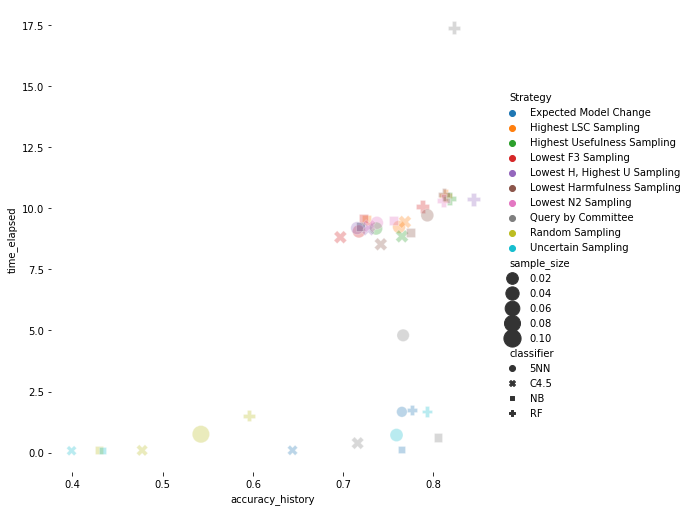

In [46]:
g = sns.relplot(
    data= df_last_result_mean,
    x="accuracy_history", y="time_elapsed",
    hue="Strategy", size="sample_size", style="classifier", height=7,
    palette=sns.color_palette(n_colors=len(pd.unique(df_last_result['Strategy']))), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

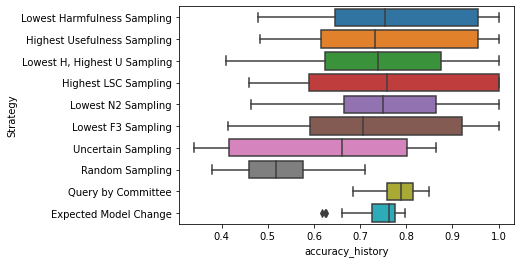

In [57]:
ax = sns.boxplot(data=df_last_result, x="accuracy_history", y="Strategy", orient="h"
                )

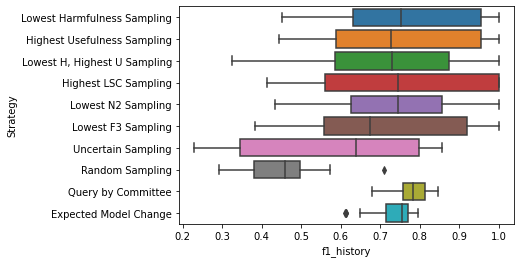

In [58]:
ax = sns.boxplot(data=df_last_result, x="f1_history", y="Strategy", orient="h"
                )

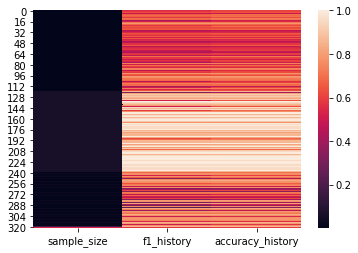

In [73]:
dfHeatMap = df_last_result.filter(['sample_size','f1_history', 'accuracy_history'], axis=1)
ax = sns.heatmap(dfHeatMap)